In [2]:
import sys
sys.path.append("../Simulations/")

import matplotlib.pyplot as plt
import theano.tensor as tt
import pymc3 as pm
from scipy import stats
import numpy as np
from skmonaco import mcquad, mcimport, mcmiser
from tqdm import *

from units import *

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [329]:
def fC(c):
    return (1 - 1/(1+c)**3)*(np.log(1+c)-c/(1+c))**-2
    
def J(M200, c200, d):
    return M200*c200**3*rho_c*200/(9*d**2)*fC(c200)

def c200_SC(M200):
    x=np.log(M200*h) # Given in terms of M_s/h in S-C&P paper
    pars=[37.5153, -1.5093, 1.636e-2, 3.66e-4, -2.89237e-5, 5.32e-7][::-1]
    return np.polyval(pars, x)

def rho_m(ms):
    """ Mass function
    """
    A0 = 2e8/M_s
    dNcdmdm = A0*(ms/M_s)**-1.9
    return dNcdmdm

def rho_nfw(r):
    """Unnormalized NFW profile density"""
    r_s = 18*kpc
    return 4*np.pi*r**2*(1/((r/r_s)*(1+r/r_s)**2))

def rho_ein_MW(r):
    """ Einasto density profile
    """ 
    r_s = 15.14*kpc
    alpha_E = 0.17
    return 4*np.pi*r**2*np.exp(-2/alpha_E*((r/r_s)**alpha_E-1)) 

def rho_ein_EAQ(r):
    """ Einasto density profile
    """ 
    r_s = 199.*kpc
    alpha_E = 0.678
    return 4*np.pi*r**2*np.exp(-2/alpha_E*((r/r_s)**alpha_E-1)) 

In [330]:
M_min = 1e6*M_s
M_max = 1e12*M_s

R_min = .1*kpc
R_max = 200*kpc

In [331]:
M_min_calib = 1e8*M_s
M_max_calib = 1e10*M_s
N_calib = 150.

In [332]:
def f(x, profile='ein'):
    M200, r = 10**x[0]*M_s, x[1]
    if profile=='nfw':
        return M200*rho_m(M200)*rho_nfw(r)
    elif profile=='ein':
        return M200*rho_m(M200)*rho_ein_EAQ(r)

def g(x, J_fid, dJ, profile='ein'):
    """
    The integrand.
    """
    M200, r = 10**x[0]*M_s, x[1]
    
    if J_fid < J(M200, c200_SC(M200/M_s), r)/(GeV**2*Centimeter**-5) < J_fid + dJ:
        return f(x, profile)
    else:
        return 0.

In [321]:
def dNdJ(J_fid, profile='nfw'):
    dJ = 1e-1*J_fid
    dNdJ_val, dNdJ_err = mcquad(g,npoints=5e5,xl=[np.log10(M_min/M_s),R_min],xu=[np.log10(M_max/M_s),R_max],nprocs=5, args=[J_fid, dJ, profile])
    return dNdJ_val/dJ, dNdJ_err/dJ

In [322]:
J_ary = np.logspace(14,25,20)

In [323]:
dNdJ_ary = [dNdJ(J) for J in tqdm_notebook(J_ary)]

In [333]:
dNdJ_ary_ein = [dNdJ(J, 'ein') for J in tqdm_notebook(J_ary)]

In [334]:
deg = 180 / np.pi
sr = 4 * np.pi
srdeg2 = sr * deg**2

In [335]:
val_NFW, _ = mcmiser(f,npoints=1e6,xl=[np.log10(M_min_calib/M_s),R_min],xu=[np.log10(M_max_calib/M_s),R_max],nprocs=4,args=['nfw'])
pref_NFW = N_calib/val_NFW

In [336]:
val_ein, _ = mcmiser(f,npoints=1e6,xl=[np.log10(M_min_calib/M_s),R_min],xu=[np.log10(M_max_calib/M_s),R_max],nprocs=4,args=['ein'])
pref_ein = N_calib/val_ein

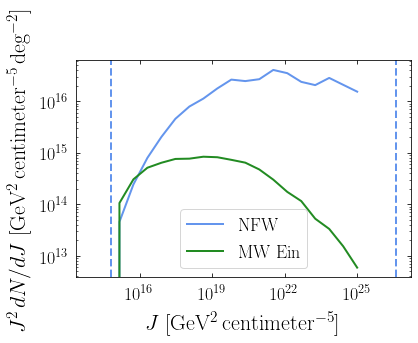

In [337]:
plt.plot(J_ary, J_ary**2*(1/srdeg2)*pref_NFW*np.array(dNdJ_ary)[:,0], label="NFW")
plt.plot(J_ary, J_ary**2*(1/srdeg2)*pref_ein*np.array(dNdJ_ary_ein)[:,0], label="MW Ein")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("$J$ [GeV$^2$\,centimeter$^{-5}$]")
plt.ylabel("$J^2\,dN/dJ$ [GeV$^2$\,centimeter$^{-5}$\,deg$^{-2}$]")

plt.axvline(J(M_min, c200_SC(M_min/M_s), R_max)/(GeV**2*Centimeter**-5), ls='--')
plt.axvline(J(M_max, c200_SC(M_max/M_s), R_min)/(GeV**2*Centimeter**-5), ls='--')

plt.legend()